### Install Dependencies

In [ ]:
!pip install --quiet google-adk 'google-cloud-aiplatform[agent_engines]==1.90.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.5/229.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/6

### Restart runtime

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Setup

Set Google Cloud project information

In [ ]:
import time
import os
os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = "1"

GCP_PROJECT_ID = "[your-project-id]" #@param {type:"string"}
if GCP_PROJECT_ID == "[your-project-id]":
  raise ValueError('Please Enter a valid project id')

os.environ['GOOGLE_CLOUD_PROJECT'] = GCP_PROJECT_ID
os.environ['GOOGLE_CLOUD_LOCATION'] ="us-central1" #@param {type:"string"}

Handle Imports

In [ ]:
from google.adk.agents import Agent
from google.adk.artifacts import InMemoryArtifactService
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types
import time
import os
import logging
import sqlite3
import pandas as pd
import glob

Define Constants

In [ ]:
APP_NAME = "nl2sql_agent"
USER_ID = "dev_user_01"
MODEL = "gemini-2.0-flash"

### Define helper functions

In [ ]:
logging.getLogger('google_genai.types').setLevel(logging.ERROR)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


async def send_query_to_agent(agent, query):
    """Sends a query to the specified agent and returns the final response.

        Args:
            agent: The agent to send the query to.
            query: The query to send to the agent.

        Returns:
            The final response from the agent as a string.
    """

    session_service = InMemorySessionService()
    artifact_service = InMemoryArtifactService()
    # Create a new session - if you want to keep the history of interruction you need to move the
    # creation of the session outside of this function. Here we create a new session per query
    session = await session_service.create_session(app_name=APP_NAME,user_id=USER_ID,)

    # Create a content object representing the user's query
    content = types.Content(role='user', parts=[types.Part(text=query)])

    # Start a timer to measure the response time
    start_time = time.time()

    # Create a runner object to manage the interaction with the agent
    runner = Runner(app_name=APP_NAME, agent=agent, artifact_service=artifact_service, session_service=session_service)

    # Run the interaction with the agent and get a stream of events
    events = runner.run(user_id=USER_ID, session_id=session.id, new_message=content)


    final_response = None
    elapsed_time_ms = 0.0

    # Loop through the events returned by the runner
    for event in events:

        is_final_response = event.is_final_response()
        function_calls = event.get_function_calls()
        function_responses = event.get_function_responses()

        if not event.content:
             continue

        if is_final_response:
            end_time = time.time()
            elapsed_time_ms = round((end_time - start_time) * 1000, 3)
            logging.info(f"Agent Response Time: {elapsed_time_ms} ms")

            final_response = event.content.parts[0].text
        elif function_calls:
            print("\n--- Function Call ---")
            print(f'Agent: {event.author}')
            for function_call in function_calls:
                print(f'Call Function: {function_call.name}')
                print(f'Argument: {function_call.args}')
            print("---------------------\n")
        elif function_responses:
            print("\n--- Function Response ---")
            print(f'Agent: {event.author}')
            for function_response in function_responses:
                    print(f'Function Name: {function_response.name}')
                    print(f'Function Results: {function_response.response}')
            print("-------------------------\n")

    return final_response


def cleanup_database():
    """Removes all SQLite database files in the current directory."""
    db_files = glob.glob('*.db')
    if db_files:
        for db_file in db_files:
            try:
                os.remove(db_file)
                print(f"Database file '{db_file}' removed.")
            except Exception as e:
                print(f"Error removing file {db_file}: {e}")
    else:
        print("No database files found to remove.")

In [ ]:
cleanup_database()

Database file 'travel_data.db' removed.
Database file 'employee_data.db' removed.


# NL2SQL Agent

### Create SQL database with employee table

In [ ]:
db_file = 'employee_data.db'

def create_employee_table():
    """Creates the employees table in the SQLite database file."""
    conn = sqlite3.connect(db_file)
    try:
        conn.execute("CREATE TABLE IF NOT EXISTS employees (id INTEGER PRIMARY KEY, name TEXT, department TEXT, salary REAL)")
        conn.execute("INSERT INTO employees (name, department, salary) VALUES ('Alice', 'Sales', 50000)")
        conn.execute("INSERT INTO employees (name, department, salary) VALUES ('Bob', 'IT', 60000)")
        conn.execute("INSERT INTO employees (name, department, salary) VALUES ('Charlie', 'Sales', 55000)")
        conn.execute("INSERT INTO employees (name, department, salary) VALUES ('David', 'IT', 65000)")
        conn.execute("INSERT INTO employees (name, department, salary) VALUES ('Eve', 'Sales', 52000)")
        conn.commit()
    except Exception as e:
        print(f"Error creating table: {e}")
    finally:
        print("Employees table created successfully.")
        conn.close()

In [ ]:
create_employee_table()

Employees table created successfully.


### Create the Tools and the Agent

In [ ]:
def execute_sql_query(query: str) -> str:
    """Executes a SQL query against the SQLite database file and returns the result as a string."""
    conn = sqlite3.connect(db_file)
    try:
        df = pd.read_sql_query(query, conn)
        return df.to_string()
    except Exception as e:
        return f"Error executing SQL query: {e}"
    finally:
        conn.close()

In [ ]:
nl2sql_agent = Agent(
    model=MODEL,
    name=APP_NAME,
    description="An agent that can answer questions about employee data by executing SQL queries.",
    instruction="""You are a helpful assistant that can answer questions about employee data.
    You have access to a tool called `execute_sql_query` which can execute SQL queries against a table named `employees` with columns `id`, `name`, `department`, and `salary`.
    When a user asks a question about the employee data, translate the question into a SQL query using the available table and columns, execute the query using the `execute_sql_query` tool, and return the result to the user.
    If you cannot answer the question using a SQL query, respond that you can only answer questions about employee data.
    """,
    generate_content_config=types.GenerateContentConfig(temperature=0.2),
    tools=[execute_sql_query],
)

### Test the Agent



In [ ]:
# Display the sample data table
print("Sample Employee Data:")
print(execute_sql_query("SELECT * FROM employees"))

Sample Employee Data:
   id     name department   salary
0   1    Alice      Sales  50000.0
1   2      Bob         IT  60000.0
2   3  Charlie      Sales  55000.0
3   4    David         IT  65000.0
4   5      Eve      Sales  52000.0


In [ ]:
query = "What are the names of all employees?"

response = await send_query_to_agent(nl2sql_agent, query)
print(f"\n==> Query: {query}")
print(f"==> Response: {response}")



--- Function Call ---
Agent: nl2sql_agent
Call Function: execute_sql_query
Argument: {'query': 'SELECT name FROM employees'}
---------------------


--- Function Response ---
Agent: nl2sql_agent
Function Name: execute_sql_query
Function Results: {'result': '      name\n0    Alice\n1      Bob\n2  Charlie\n3    David\n4      Eve'}
-------------------------


==> Query: What are the names of all employees?
==> Response: The names of all employees are Alice, Bob, Charlie, David, and Eve.



In [ ]:
query = "What is the average salary?" # 56400

response = await send_query_to_agent(nl2sql_agent, query)
print(f"\n==> Query: {query}")
print(f"==> Response: {response}")



--- Function Call ---
Agent: nl2sql_agent
Call Function: execute_sql_query
Argument: {'query': 'SELECT avg(salary) FROM employees'}
---------------------


--- Function Response ---
Agent: nl2sql_agent
Function Name: execute_sql_query
Function Results: {'result': '   avg(salary)\n0      56400.0'}
-------------------------


==> Query: What is the average salary?
==> Response: The average salary is 56400.0.


In [ ]:
query = "What is the difference in avg salaries of someone in IT vs Sales " # 10166.67

response = await send_query_to_agent(nl2sql_agent, query)
print(f"\n==> Query: {query}")
print(f"==> Response: {response}")



--- Function Call ---
Agent: nl2sql_agent
Call Function: execute_sql_query
Argument: {'query': "SELECT AVG(CASE WHEN department = 'IT' THEN salary ELSE NULL END) - AVG(CASE WHEN department = 'Sales' THEN salary ELSE NULL END) FROM employees"}
---------------------


--- Function Response ---
Agent: nl2sql_agent
Function Name: execute_sql_query
Function Results: {'result': "   AVG(CASE WHEN department = 'IT' THEN salary ELSE NULL END) - AVG(CASE WHEN department = 'Sales' THEN salary ELSE NULL END)\n0                                                                                                                10166.666667"}
-------------------------


==> Query: What is the difference in avg salaries of someone in IT vs Sales 
==> Response: The difference in average salaries between the IT and Sales departments is 10166.67.


# NL2SQL Agent with Multiple Tables

### Create the Travel Database with multiple tables

In [ ]:
# Define table structures and sample data

# Flights table
flights_table_definition = """
CREATE TABLE IF NOT EXISTS flights (
    flight_id INTEGER PRIMARY KEY,
    origin TEXT,
    destination TEXT,
    departure_time TEXT,
    arrival_time TEXT,
    price REAL
)
"""
flights_sample_data = [
    (1, 'JFK', 'LAX', '2025-06-01 08:00:00', '2025-06-01 11:00:00', 350.00),
    (2, 'LAX', 'JFK', '2025-06-01 12:00:00', '2025-06-01 20:00:00', 320.00),
    (3, 'JFK', 'MIA', '2025-06-02 09:00:00', '2025-06-02 12:00:00', 250.00),
    (4, 'MIA', 'JFK', '2025-06-02 13:00:00', '2025-06-02 16:00:00', 230.00),
    (5, 'LAX', 'MIA', '2025-06-03 10:00:00', '2025-06-03 17:00:00', 400.00),
]

# Hotels table
hotels_table_definition = """
CREATE TABLE IF NOT EXISTS hotels (
    hotel_id INTEGER PRIMARY KEY,
    name TEXT,
    location TEXT,
    price_per_night REAL,
    rating REAL
)
"""
hotels_sample_data = [
    (101, 'Hilton LAX', 'LAX', 150.00, 4.5),
    (102, 'Marriott JFK', 'JFK', 180.00, 4.8),
    (103, 'Hyatt Regency Miami', 'MIA', 120.00, 4.2),
    (104, 'Embassy Suites LAX', 'LAX', 160.00, 4.4),
]

# Bookings table
bookings_table_definition = """
CREATE TABLE IF NOT EXISTS bookings (
    booking_id INTEGER PRIMARY KEY,
    customer_name TEXT,
    type TEXT CHECK(type IN ('flight', 'hotel')),
    item_id INTEGER,
    booking_date TEXT
)
"""
bookings_sample_data = [
    (1001, 'Alice', 'flight', 1, '2025-05-20'),
    (1002, 'Bob', 'hotel', 101, '2025-05-21'),
    (1003, 'Charlie', 'flight', 3, '2025-05-22'),
    (1004, 'David', 'hotel', 103, '2025-05-23'),
    (1005, 'Alice', 'hotel', 102, '2025-05-23'),
    (1006, 'Bob', 'flight', 2, '2025-05-24'),
]

print("Table structures and sample data defined.")

Table structures and sample data defined.


In [ ]:
def create_travel_tables(db_file: str):
    """Creates the travel tables in the SQLite database file."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute(flights_table_definition)
        conn.execute(hotels_table_definition)
        conn.execute(bookings_table_definition)
        conn.commit()
        print("Travel tables created successfully.")
    except sqlite3.Error as e:
        print(f"Error creating tables: {e}")
    finally:
        if conn:
            conn.close()

def insert_travel_data(db_file: str, table_name: str, data):
    """Inserts sample data into a specified table in the SQLite database file."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        if table_name == "flights":
            conn.executemany("INSERT INTO flights (flight_id, origin, destination, departure_time, arrival_time, price) VALUES (?, ?, ?, ?, ?, ?)", data)
        elif table_name == "hotels":
            conn.executemany("INSERT INTO hotels (hotel_id, name, location, price_per_night, rating) VALUES (?, ?, ?, ?, ?)", data)
        elif table_name == "bookings":
            conn.executemany("INSERT INTO bookings (booking_id, customer_name, type, item_id, booking_date) VALUES (?, ?, ?, ?, ?)", data)
        else:
            print(f"Unknown table name: {table_name}")
            return
        conn.commit()
        print(f"Sample data inserted into {table_name} successfully.")
    except sqlite3.Error as e:
        print(f"Error inserting data into {table_name}: {e}")
    finally:
        if conn:
            conn.close()

In [ ]:
travel_db_file = 'travel_data.db'
create_travel_tables(travel_db_file)

insert_travel_data(travel_db_file, "flights", flights_sample_data)
insert_travel_data(travel_db_file, "hotels", hotels_sample_data)
insert_travel_data(travel_db_file, "bookings", bookings_sample_data)


Travel tables created successfully.
Error inserting data into flights: UNIQUE constraint failed: flights.flight_id
Error inserting data into hotels: UNIQUE constraint failed: hotels.hotel_id
Error inserting data into bookings: UNIQUE constraint failed: bookings.booking_id


### Create the Tools and the Agent

In [ ]:
def execute_sql_query(query: str) -> str:
    """Executes a SQL query against the SQLite database file and returns the result as a string."""
    db_file = 'travel_data.db'
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(query, conn)
        return df.to_string()
    except Exception as e:
        return f"Error executing SQL query: {e}"
    finally:
        if conn:
            conn.close()

In [ ]:
nl2sql_agent = Agent(
    model=MODEL,
    name=APP_NAME,
    description="An agent that can answer questions about travel data by executing SQL queries.",
    instruction="""You are a helpful assistant that can answer questions about travel data.
    You have access to a tool called `execute_sql_query` which can execute SQL queries against a SQLite database.

    The database contains the following tables:

    - `flights`: Contains flight information.
        - Columns: `flight_id` (INTEGER), `origin` (TEXT), `destination` (TEXT), `departure_time` (TEXT), `arrival_time` (TEXT), `price` (REAL)

    - `hotels`: Contains hotel details.
        - Columns: `hotel_id` (INTEGER), `name` (TEXT), `location` (TEXT), `price_per_night` (REAL), `rating` (REAL)

    - `bookings`: Records customer bookings for flights and hotels.
        - Columns: `booking_id` (INTEGER), `customer_name` (TEXT), `type` (TEXT, 'flight' or 'hotel'), `item_id` (INTEGER), `booking_date` (TEXT)

    When a user asks a question about the data, translate the question into a SQL query using the available tables and columns, execute the query using the `execute_sql_query` tool, and return the result to the user.
    If you cannot answer the question using a SQL query based on the available tables, respond that you can only answer questions about the travel data.
    """,
    generate_content_config=types.GenerateContentConfig(temperature=0.2),
    tools=[execute_sql_query],
)

### Test the Agent

In [ ]:
print("\nContents of tables:")
print("Flights:")
print(execute_sql_query("SELECT * FROM flights"))
print("Hotels:")
print(execute_sql_query("SELECT * FROM hotels"))
print("Bookings:")
print(execute_sql_query("SELECT * FROM bookings"))


Contents of tables:
Flights:
   flight_id origin destination       departure_time         arrival_time  price
0          1    JFK         LAX  2025-06-01 08:00:00  2025-06-01 11:00:00  350.0
1          2    LAX         JFK  2025-06-01 12:00:00  2025-06-01 20:00:00  320.0
2          3    JFK         MIA  2025-06-02 09:00:00  2025-06-02 12:00:00  250.0
3          4    MIA         JFK  2025-06-02 13:00:00  2025-06-02 16:00:00  230.0
4          5    LAX         MIA  2025-06-03 10:00:00  2025-06-03 17:00:00  400.0
Hotels:
   hotel_id                 name location  price_per_night  rating
0       101           Hilton LAX      LAX            150.0     4.5
1       102         Marriott JFK      JFK            180.0     4.8
2       103  Hyatt Regency Miami      MIA            120.0     4.2
3       104   Embassy Suites LAX      LAX            160.0     4.4
Bookings:
   booking_id customer_name    type  item_id booking_date
0        1001         Alice  flight        1   2025-05-20
1        1002  

In [ ]:
query = "Find the names of customers who booked flights to LAX."
response = await send_query_to_agent(nl2sql_agent, query)
print(f"\n==> Query: {query}")
print(f"==> Response: {response}")
print("-" * 30)


--- Function Call ---
Agent: nl2sql_agent
Call Function: execute_sql_query
Argument: {'query': "SELECT DISTINCT T1.customer_name FROM bookings AS T1 JOIN flights AS T2 ON T1.item_id = T2.flight_id WHERE T2.destination = 'LAX'"}
---------------------


--- Function Response ---
Agent: nl2sql_agent
Function Name: execute_sql_query
Function Results: {'result': '  customer_name\n0         Alice'}
-------------------------


==> Query: Find the names of customers who booked flights to LAX.
==> Response: Alice is the customer who booked flights to LAX.
------------------------------


In [ ]:
query = "List the hotels booked by Alice."
response = await send_query_to_agent(nl2sql_agent, query)
print(f"\n==> Query: {query}")
print(f"==> Response: {response}")
print("-" * 30)


--- Function Call ---
Agent: nl2sql_agent
Call Function: execute_sql_query
Argument: {'query': "SELECT T1.name FROM hotels AS T1 JOIN bookings AS T2 ON T1.hotel_id = T2.item_id WHERE T2.customer_name = 'Alice' AND T2.type = 'hotel'"}
---------------------


--- Function Response ---
Agent: nl2sql_agent
Function Name: execute_sql_query
Function Results: {'result': '           name\n0  Marriott JFK'}
-------------------------


==> Query: List the hotels booked by Alice.
==> Response: Marriott JFK
------------------------------


In [ ]:
cleanup_database()

## NL2SQL Agent with Multiple Tables and Basic Visualization

### Redefine Tools and Agent for Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3

def execute_sql_query_with_df(query: str) -> str:
    """Executes a SQL query against the SQLite database file, returns the result as a string, and visualizes if possible."""
    db_file = 'travel_data.db'
    conn = None
    df = None
    result_string = ""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(query, conn)
        result_string = df.to_string()

        visualize_data(df, query)

    except Exception as e:
        result_string = f"Error executing SQL query: {e}"
        df = None
    finally:
        if conn:
            conn.close()
    return result_string

def visualize_data(df: pd.DataFrame, query: str):
    """Generates a visualization based on the DataFrame and query."""
    if df is None or df.empty:
        print("No data to visualize.")
        return

    # Basic visualization logic - can be expanded based on query intent/NL2Python
    try:
        if len(df.columns) == 2:
            # Try to plot if two columns, assuming one is categorical/label and the other is numerical
            # Check if the second column is numeric for plotting
            if pd.api.types.is_numeric_dtype(df.iloc[:, 1]):
                df.set_index(df.columns[0], inplace=True)
                df.plot(kind='bar', legend=False)
                plt.title("Visualization of Query Results")
                plt.xlabel(df.index.name)
                plt.ylabel(df.columns[0])
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                print("Second column is not numeric, skipping automatic visualization.")
        elif len(df.columns) > 2:
            print("DataFrame has more than two columns, skipping automatic visualization.")
        else:
             print("DataFrame has only one column, skipping automatic visualization.")

    except Exception as e:
        print(f"Could not generate visualization: {e}")

In [ ]:
import logging
import time
from google.genai import types
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.artifacts import InMemoryArtifactService


logging.getLogger('google_genai.types').setLevel(logging.ERROR)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


async def send_query_to_agent(agent, query):
    """Sends a query to the specified agent and returns the final response and any executed SQL query."""

    session_service = InMemorySessionService()
    artifact_service = InMemoryArtifactService()
    session = await session_service.create_session(app_name=APP_NAME,user_id=USER_ID,)

    content = types.Content(role='user', parts=[types.Part(text=query)])

    start_time = time.time()

    runner = Runner(app_name=APP_NAME, agent=agent, artifact_service=artifact_service, session_service=session_service)

    events = runner.run(user_id=USER_ID, session_id=session.id, new_message=content)


    final_response = None
    elapsed_time_ms = 0.0
    executed_sql_query = None

    for event in events:

        is_final_response = event.is_final_response()
        function_calls = event.get_function_calls()
        function_responses = event.get_function_responses()

        if not event.content:
             continue

        if is_final_response:
            end_time = time.time()
            elapsed_time_ms = round((end_time - start_time) * 1000, 3)
            logging.info(f"Agent Response Time: {elapsed_time_ms} ms")

            final_response = event.content.parts[0].text
            break

        elif function_calls:
            print("\n--- Function Call ---")
            print(f'Agent: {event.author}')
            for function_call in function_calls:
                print(f'Call Function: {function_call.name}')
                print(f'Argument: {function_call.args}')
                if function_call.name == "execute_sql_query_with_df":
                     executed_sql_query = function_call.args.get('query', '')
            print("---------------------\n")

        elif function_responses:
            print("\n--- Function Response ---")
            print(f'Agent: {event.author}')
            for function_response in function_responses:
                    print(f'Function Name: {function_response.name}')
                    print(f'Function Results: {function_response.response}')
            print("-------------------------\n")

    return final_response, executed_sql_query

In [ ]:
nl2sql_agent_viz = Agent(
    model=MODEL,
    name=APP_NAME,
    description="An agent that can answer questions about travel data by executing SQL queries and visualizing the results.",
    instruction="""You are a helpful assistant that can answer questions about travel data.
    You have access to a tool called `execute_sql_query` which can execute SQL queries against a SQLite database.

    The database contains the following tables:

    - `flights`: Contains flight information.
        - Columns: `flight_id` (INTEGER), `origin` (TEXT), `destination` (TEXT), `departure_time` (TEXT), `arrival_time` (TEXT), `price` (REAL)

    - `hotels`: Contains hotel details.
        - Columns: `hotel_id` (INTEGER), `name` (TEXT), `location` (TEXT), `price_per_night` (REAL), `rating` (REAL)

    - `bookings`: Records customer bookings for flights and hotels.
        - Columns: `booking_id` (INTEGER), `customer_name` (TEXT), `type` (TEXT, 'flight' or 'hotel'), `item_id` (INTEGER), `booking_date` (TEXT)

    When a user asks a question about the data, translate the question into a SQL query using the available tables and columns, execute the query using the `execute_sql_query` tool, and return the result to the user.
    If the query result is suitable for visualization (e.g., a small table with a few columns), generate a visualization to accompany the text response.
    If you cannot answer the question using a SQL query based on the available tables, respond that you can only answer questions about the travel data.
    """,
    generate_content_config=types.GenerateContentConfig(temperature=0.2),
    tools=[execute_sql_query_with_df],
)


--- Function Call ---
Agent: nl2sql_agent
Call Function: execute_sql_query_with_df
Argument: {'query': 'SELECT origin, AVG(price) FROM flights GROUP BY origin'}
---------------------



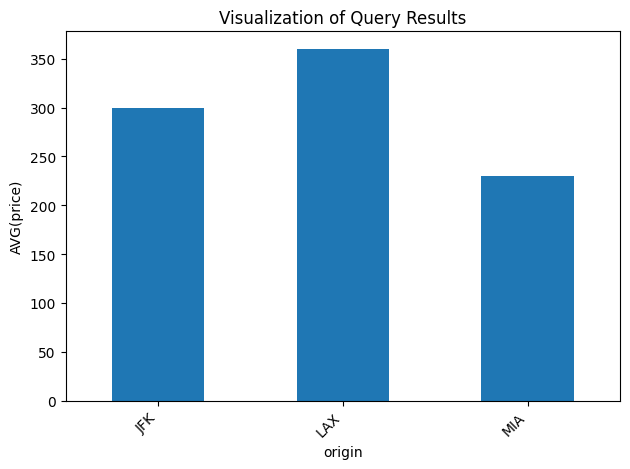


--- Function Response ---
Agent: nl2sql_agent
Function Name: execute_sql_query_with_df
Function Results: {'result': '  origin  AVG(price)\n0    JFK       300.0\n1    LAX       360.0\n2    MIA       230.0'}
-------------------------


==> Query: Find the average price of flights for each origin city.
==> Response: The average price of flights from JFK is $300.0, from LAX is $360.0, and from MIA is $230.0.


In [ ]:
query = "Find the average price of flights for each origin city."
response, executed_sql_query = await send_query_to_agent(nl2sql_agent_viz, query)

print(f"\n==> Query: {query}")
print(f"==> Response: {response}")